# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the RealNVP](#build)
3. [Train the RealNVP](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [3]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

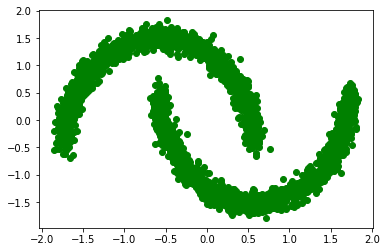

In [4]:
# Load the data
data = datasets.make_moons(3000, noise=0.05)[0].astype("float32")
norm = keras.layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(normalized_data.numpy()[:,0], normalized_data.numpy()[:,1], c = 'green')
plt.show()

## 2. Build the RealNVP network <a name="build"></a>

In [5]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = keras.layers.Input(shape=input_dim)
    
    s_layer_1 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=keras.regularizers.l2(reg)
    )(s_layer_4)
    
    t_layer_1 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_dim, activation="linear", kernel_regularizer=keras.regularizers.l2(reg)
    )(t_layer_4)

    return keras.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [6]:
class RealNVP(keras.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(input_dim, coupling_dim, regularization) for i in range(coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis = 1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
model = RealNVP(
    input_dim = INPUT_DIM
    , coupling_layers= COUPLING_LAYERS
    , coupling_dim = COUPLING_DIM
    , regularization = REGULARIZATION
)

## 3. Train the RealNVP network <a name="train"></a>

In [7]:
# Compile and train the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [8]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples
  
    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples)
        
        return x, z, samples

    def display(self, x, z, samples, save_to = None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)
        
        axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r", s= 1)
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s= 1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s= 1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s= 1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])
        
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            out = plt.savefig(save_to)
            print(f'\nSaved to {save_to}')
            
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(x, z, samples, save_to = "./output/generated_img_%03d.png" % (epoch))

img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
94/94 [==============================] - 1s 4ms/step

Saved to ./output/generated_img_000.png


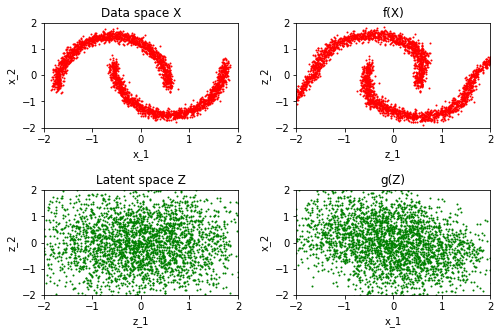

12/12 [==============================] - 4s 169ms/step - loss: 2.7440
Epoch 2/300
12/12 [==============================] - 0s 14ms/step - loss: 2.6560
Epoch 3/300
12/12 [==============================] - 0s 13ms/step - loss: 2.6247
Epoch 4/300
12/12 [==============================] - 0s 13ms/step - loss: 2.5885
Epoch 5/300
12/12 [==============================] - 0s 19ms/step - loss: 2.5465
Epoch 6/300
12/12 [==============================] - 0s 16ms/step - loss: 2.5123
Epoch 7/300
12/12 [==============================] - 0s 16ms/step - loss: 2.4809
Epoch 8/300
12/12 [==============================] - 0s 30ms/step - loss: 2.4543
Epoch 9/300
12/12 [==============================] - 0s 13ms/step - loss: 2.4323
Epoch 10/300
12/12 [==============================] - 0s 14ms/step - loss: 2.4122
Epoch 11/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_010.png


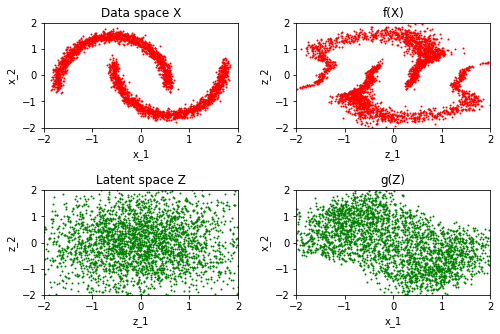

12/12 [==============================] - 2s 169ms/step - loss: 2.3975
Epoch 12/300
12/12 [==============================] - 0s 32ms/step - loss: 2.3836
Epoch 13/300
12/12 [==============================] - 0s 35ms/step - loss: 2.3683
Epoch 14/300
12/12 [==============================] - 0s 26ms/step - loss: 2.3542
Epoch 15/300
12/12 [==============================] - 0s 22ms/step - loss: 2.3381
Epoch 16/300
12/12 [==============================] - 0s 17ms/step - loss: 2.3223
Epoch 17/300
12/12 [==============================] - 0s 19ms/step - loss: 2.3050
Epoch 18/300
12/12 [==============================] - 0s 30ms/step - loss: 2.2902
Epoch 19/300
12/12 [==============================] - 0s 27ms/step - loss: 2.2739
Epoch 20/300
12/12 [==============================] - 0s 23ms/step - loss: 2.2697
Epoch 21/300
94/94 [==============================] - 0s 5ms/step

Saved to ./output/generated_img_020.png


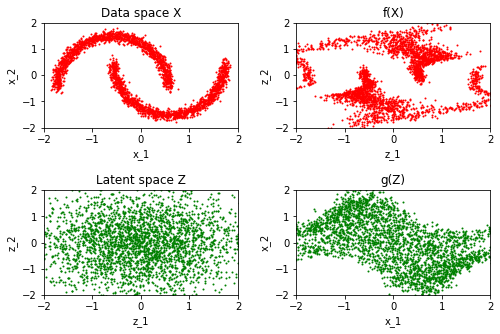

12/12 [==============================] - 2s 151ms/step - loss: 2.2522
Epoch 22/300
12/12 [==============================] - 0s 16ms/step - loss: 2.2262
Epoch 23/300
12/12 [==============================] - 0s 20ms/step - loss: 2.2192
Epoch 24/300
12/12 [==============================] - 0s 18ms/step - loss: 2.2040
Epoch 25/300
12/12 [==============================] - 0s 17ms/step - loss: 2.2052
Epoch 26/300
12/12 [==============================] - 0s 16ms/step - loss: 2.1749
Epoch 27/300
12/12 [==============================] - 0s 18ms/step - loss: 2.1511
Epoch 28/300
12/12 [==============================] - 0s 17ms/step - loss: 2.1435
Epoch 29/300
12/12 [==============================] - 0s 17ms/step - loss: 2.1292
Epoch 30/300
12/12 [==============================] - 0s 26ms/step - loss: 2.1151
Epoch 31/300
94/94 [==============================] - 0s 5ms/step

Saved to ./output/generated_img_030.png


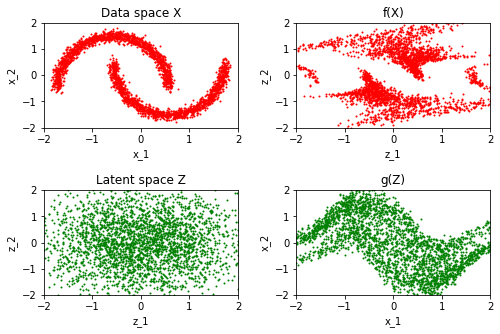

12/12 [==============================] - 2s 158ms/step - loss: 2.1024
Epoch 32/300
12/12 [==============================] - 0s 25ms/step - loss: 2.0926
Epoch 33/300
12/12 [==============================] - 0s 22ms/step - loss: 2.0837
Epoch 34/300
12/12 [==============================] - 0s 20ms/step - loss: 2.0746
Epoch 35/300
12/12 [==============================] - 0s 36ms/step - loss: 2.0770
Epoch 36/300
12/12 [==============================] - 0s 19ms/step - loss: 2.0532
Epoch 37/300
12/12 [==============================] - 0s 19ms/step - loss: 2.0578
Epoch 38/300
12/12 [==============================] - 0s 19ms/step - loss: 2.0601
Epoch 39/300
12/12 [==============================] - 0s 19ms/step - loss: 2.0560
Epoch 40/300
12/12 [==============================] - 0s 17ms/step - loss: 2.0422
Epoch 41/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_040.png


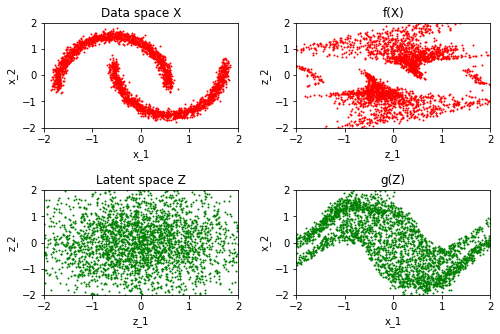

12/12 [==============================] - 3s 234ms/step - loss: 2.0245
Epoch 42/300
12/12 [==============================] - 0s 28ms/step - loss: 2.0269
Epoch 43/300
12/12 [==============================] - 0s 27ms/step - loss: 2.0485
Epoch 44/300
12/12 [==============================] - 0s 31ms/step - loss: 2.0170
Epoch 45/300
12/12 [==============================] - 0s 29ms/step - loss: 2.0149
Epoch 46/300
12/12 [==============================] - 0s 30ms/step - loss: 2.0193
Epoch 47/300
12/12 [==============================] - 0s 30ms/step - loss: 1.9885
Epoch 48/300
12/12 [==============================] - 0s 30ms/step - loss: 2.0057
Epoch 49/300
12/12 [==============================] - 0s 29ms/step - loss: 2.0001
Epoch 50/300
12/12 [==============================] - 0s 17ms/step - loss: 1.9894
Epoch 51/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_050.png


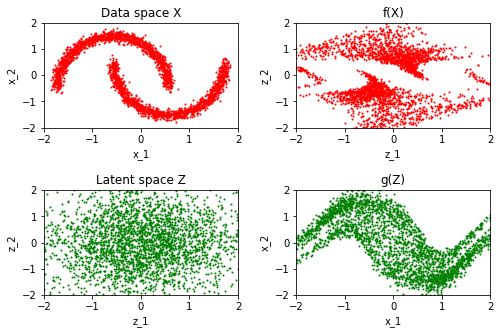

12/12 [==============================] - 2s 183ms/step - loss: 2.0030
Epoch 52/300
12/12 [==============================] - 0s 23ms/step - loss: 2.0164
Epoch 53/300
12/12 [==============================] - 0s 20ms/step - loss: 1.9782
Epoch 54/300
12/12 [==============================] - 0s 25ms/step - loss: 1.9803
Epoch 55/300
12/12 [==============================] - 0s 20ms/step - loss: 1.9733
Epoch 56/300
12/12 [==============================] - 0s 21ms/step - loss: 1.9610
Epoch 57/300
12/12 [==============================] - 0s 18ms/step - loss: 1.9489
Epoch 58/300
12/12 [==============================] - 0s 17ms/step - loss: 1.9577
Epoch 59/300
12/12 [==============================] - 0s 17ms/step - loss: 1.9787
Epoch 60/300
12/12 [==============================] - 0s 23ms/step - loss: 1.9599
Epoch 61/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_060.png


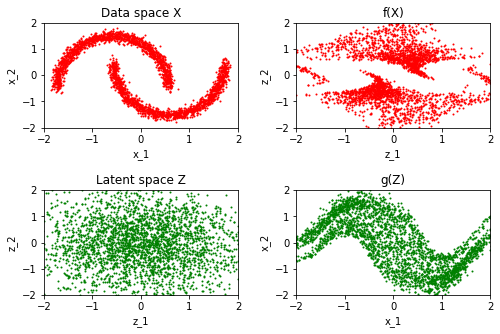

12/12 [==============================] - 2s 147ms/step - loss: 1.9659
Epoch 62/300
12/12 [==============================] - 0s 20ms/step - loss: 1.9627
Epoch 63/300
12/12 [==============================] - 0s 17ms/step - loss: 1.9489
Epoch 64/300
12/12 [==============================] - 0s 19ms/step - loss: 1.9374
Epoch 65/300
12/12 [==============================] - 0s 24ms/step - loss: 1.9423
Epoch 66/300
12/12 [==============================] - 0s 24ms/step - loss: 1.9450
Epoch 67/300
12/12 [==============================] - 0s 23ms/step - loss: 1.9515
Epoch 68/300
12/12 [==============================] - 0s 27ms/step - loss: 1.9398
Epoch 69/300
12/12 [==============================] - 0s 20ms/step - loss: 1.9355
Epoch 70/300
12/12 [==============================] - 0s 21ms/step - loss: 1.9325
Epoch 71/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_070.png


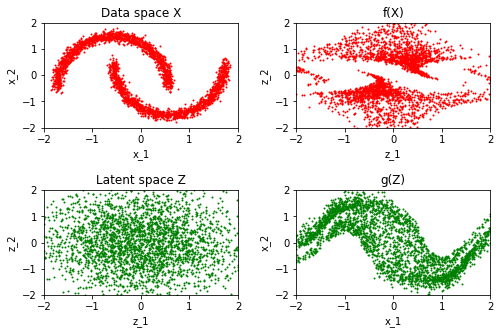

12/12 [==============================] - 2s 174ms/step - loss: 1.9406
Epoch 72/300
12/12 [==============================] - 0s 15ms/step - loss: 1.9379
Epoch 73/300
12/12 [==============================] - 0s 21ms/step - loss: 1.9428
Epoch 74/300
12/12 [==============================] - 0s 21ms/step - loss: 1.9502
Epoch 75/300
12/12 [==============================] - 0s 18ms/step - loss: 1.9446
Epoch 76/300
12/12 [==============================] - 0s 30ms/step - loss: 1.9339
Epoch 77/300
12/12 [==============================] - 0s 22ms/step - loss: 1.9267
Epoch 78/300
12/12 [==============================] - 0s 19ms/step - loss: 1.9321
Epoch 79/300
12/12 [==============================] - 0s 21ms/step - loss: 1.9344
Epoch 80/300
12/12 [==============================] - 0s 22ms/step - loss: 1.9207
Epoch 81/300
94/94 [==============================] - 0s 5ms/step

Saved to ./output/generated_img_080.png


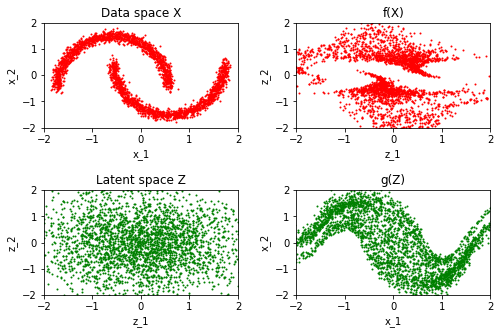

12/12 [==============================] - 2s 161ms/step - loss: 1.9489
Epoch 82/300
12/12 [==============================] - 0s 25ms/step - loss: 1.9422
Epoch 83/300
12/12 [==============================] - 0s 24ms/step - loss: 1.9653
Epoch 84/300
12/12 [==============================] - 0s 25ms/step - loss: 1.9437
Epoch 85/300
12/12 [==============================] - 0s 29ms/step - loss: 1.9139
Epoch 86/300
12/12 [==============================] - 1s 44ms/step - loss: 1.9155
Epoch 87/300
12/12 [==============================] - 0s 29ms/step - loss: 1.9064
Epoch 88/300
12/12 [==============================] - 0s 38ms/step - loss: 1.9101
Epoch 89/300
12/12 [==============================] - 0s 35ms/step - loss: 1.9114
Epoch 90/300
12/12 [==============================] - 0s 35ms/step - loss: 1.9149
Epoch 91/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_090.png


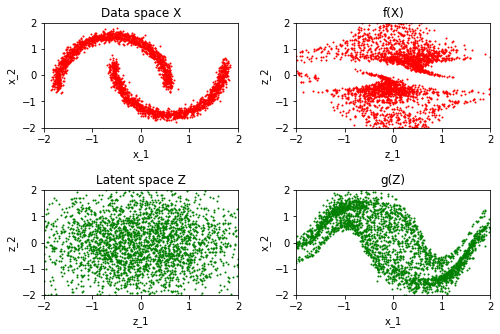

12/12 [==============================] - 2s 177ms/step - loss: 1.8966
Epoch 92/300
12/12 [==============================] - 0s 28ms/step - loss: 1.9064
Epoch 93/300
12/12 [==============================] - 0s 26ms/step - loss: 1.8936
Epoch 94/300
12/12 [==============================] - 0s 27ms/step - loss: 1.9216
Epoch 95/300
12/12 [==============================] - 0s 31ms/step - loss: 1.9052
Epoch 96/300
12/12 [==============================] - 0s 25ms/step - loss: 1.8976
Epoch 97/300
12/12 [==============================] - 0s 34ms/step - loss: 1.8947
Epoch 98/300
12/12 [==============================] - 0s 27ms/step - loss: 1.9286
Epoch 99/300
12/12 [==============================] - 0s 30ms/step - loss: 1.9300
Epoch 100/300
12/12 [==============================] - 0s 32ms/step - loss: 1.8911
Epoch 101/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_100.png


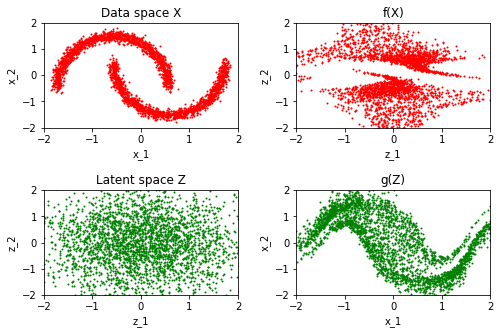

12/12 [==============================] - 2s 167ms/step - loss: 1.8905
Epoch 102/300
12/12 [==============================] - 0s 17ms/step - loss: 1.9154
Epoch 103/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8834
Epoch 104/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8842
Epoch 105/300
12/12 [==============================] - 0s 17ms/step - loss: 1.8779
Epoch 106/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8747
Epoch 107/300
12/12 [==============================] - 0s 17ms/step - loss: 1.8945
Epoch 108/300
12/12 [==============================] - 0s 16ms/step - loss: 1.8627
Epoch 109/300
12/12 [==============================] - 0s 19ms/step - loss: 1.8430
Epoch 110/300
12/12 [==============================] - 0s 19ms/step - loss: 1.8373
Epoch 111/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_110.png


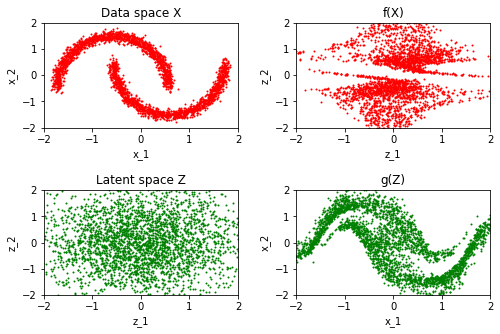

12/12 [==============================] - 2s 136ms/step - loss: 1.8178
Epoch 112/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8190
Epoch 113/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8159
Epoch 114/300
12/12 [==============================] - 0s 15ms/step - loss: 1.8011
Epoch 115/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7979
Epoch 116/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7830
Epoch 117/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7930
Epoch 118/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7625
Epoch 119/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7488
Epoch 120/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7675
Epoch 121/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_120.png


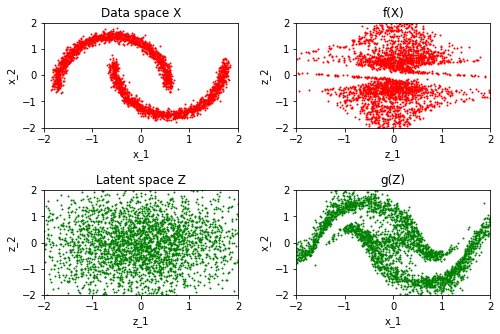

12/12 [==============================] - 1s 125ms/step - loss: 1.7509
Epoch 122/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7426
Epoch 123/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7566
Epoch 124/300
12/12 [==============================] - 0s 24ms/step - loss: 1.7480
Epoch 125/300
12/12 [==============================] - 0s 38ms/step - loss: 1.7476
Epoch 126/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7550
Epoch 127/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7426
Epoch 128/300
12/12 [==============================] - 0s 22ms/step - loss: 1.7379
Epoch 129/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7330
Epoch 130/300
12/12 [==============================] - 0s 28ms/step - loss: 1.7469
Epoch 131/300
94/94 [==============================] - 0s 5ms/step

Saved to ./output/generated_img_130.png


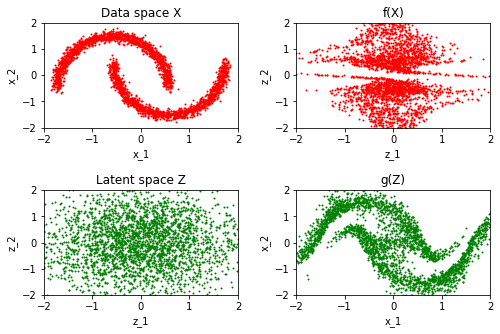

12/12 [==============================] - 2s 159ms/step - loss: 1.7436
Epoch 132/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7318
Epoch 133/300
12/12 [==============================] - 0s 19ms/step - loss: 1.7288
Epoch 134/300
12/12 [==============================] - 0s 28ms/step - loss: 1.7333
Epoch 135/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7419
Epoch 136/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7485
Epoch 137/300
12/12 [==============================] - 0s 31ms/step - loss: 1.7295
Epoch 138/300
12/12 [==============================] - 0s 30ms/step - loss: 1.7347
Epoch 139/300
12/12 [==============================] - 0s 31ms/step - loss: 1.7254
Epoch 140/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7284
Epoch 141/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_140.png


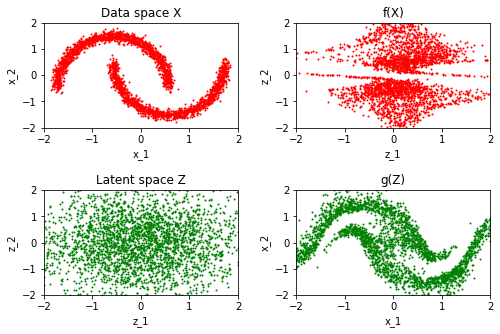

12/12 [==============================] - 2s 173ms/step - loss: 1.7254
Epoch 142/300
12/12 [==============================] - 0s 21ms/step - loss: 1.7448
Epoch 143/300
12/12 [==============================] - 0s 32ms/step - loss: 1.7440
Epoch 144/300
12/12 [==============================] - 0s 24ms/step - loss: 1.7349
Epoch 145/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7255
Epoch 146/300
12/12 [==============================] - 0s 29ms/step - loss: 1.7297
Epoch 147/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7296
Epoch 148/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7281
Epoch 149/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7274
Epoch 150/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7271
Epoch 151/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_150.png


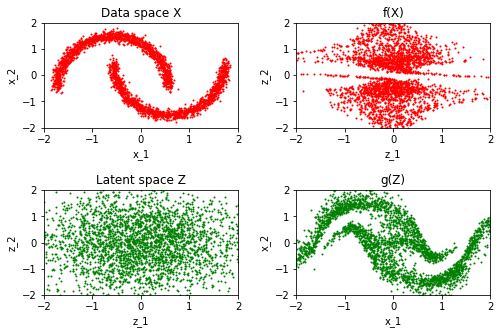

12/12 [==============================] - 2s 199ms/step - loss: 1.7213
Epoch 152/300
12/12 [==============================] - 0s 34ms/step - loss: 1.7221
Epoch 153/300
12/12 [==============================] - 0s 27ms/step - loss: 1.7220
Epoch 154/300
12/12 [==============================] - 0s 19ms/step - loss: 1.7166
Epoch 155/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7168
Epoch 156/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7199
Epoch 157/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7216
Epoch 158/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7215
Epoch 159/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7196
Epoch 160/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7203
Epoch 161/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_160.png


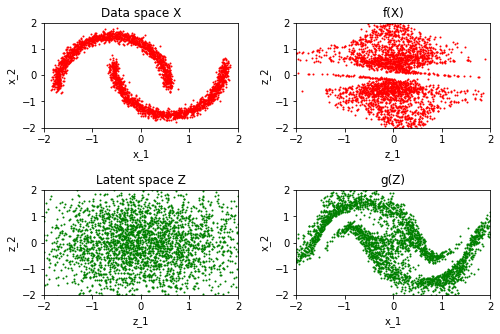

12/12 [==============================] - 2s 188ms/step - loss: 1.7277
Epoch 162/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7202
Epoch 163/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7260
Epoch 164/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7194
Epoch 165/300
12/12 [==============================] - 1s 64ms/step - loss: 1.7185
Epoch 166/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7169
Epoch 167/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7162
Epoch 168/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7122
Epoch 169/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7157
Epoch 170/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7116
Epoch 171/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_170.png


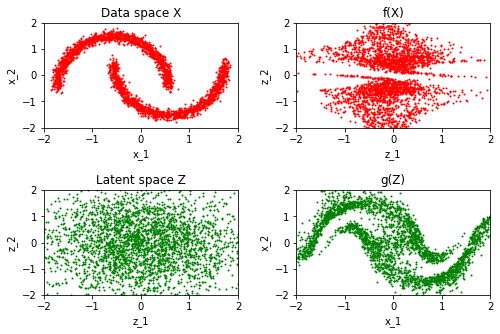

12/12 [==============================] - 1s 131ms/step - loss: 1.7164
Epoch 172/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7177
Epoch 173/300
12/12 [==============================] - 0s 34ms/step - loss: 1.7230
Epoch 174/300
12/12 [==============================] - 0s 31ms/step - loss: 1.7167
Epoch 175/300
12/12 [==============================] - 0s 37ms/step - loss: 1.7117
Epoch 176/300
12/12 [==============================] - 0s 35ms/step - loss: 1.7095
Epoch 177/300
12/12 [==============================] - 0s 29ms/step - loss: 1.7179
Epoch 178/300
12/12 [==============================] - 1s 110ms/step - loss: 1.7153
Epoch 179/300
12/12 [==============================] - 0s 19ms/step - loss: 1.7228
Epoch 180/300
12/12 [==============================] - 0s 31ms/step - loss: 1.7324
Epoch 181/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_180.png


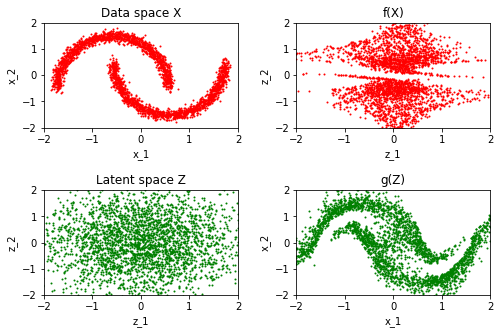

12/12 [==============================] - 2s 168ms/step - loss: 1.7177
Epoch 182/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7180
Epoch 183/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7123
Epoch 184/300
12/12 [==============================] - 0s 19ms/step - loss: 1.7102
Epoch 185/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7068
Epoch 186/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7122
Epoch 187/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7099
Epoch 188/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7101
Epoch 189/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7068
Epoch 190/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7100
Epoch 191/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_190.png


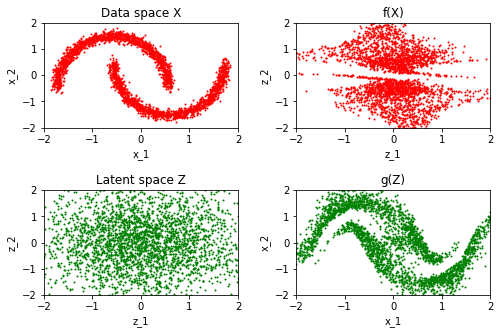

12/12 [==============================] - 1s 125ms/step - loss: 1.7199
Epoch 192/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7205
Epoch 193/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7262
Epoch 194/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7123
Epoch 195/300
12/12 [==============================] - 0s 32ms/step - loss: 1.7140
Epoch 196/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7135
Epoch 197/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7088
Epoch 198/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7051
Epoch 199/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7153
Epoch 200/300
12/12 [==============================] - 0s 22ms/step - loss: 1.7088
Epoch 201/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_200.png


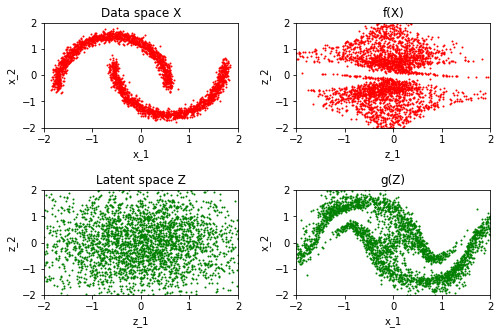

12/12 [==============================] - 1s 130ms/step - loss: 1.7106
Epoch 202/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7210
Epoch 203/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7332
Epoch 204/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7225
Epoch 205/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7284
Epoch 206/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7186
Epoch 207/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7092
Epoch 208/300
12/12 [==============================] - 0s 26ms/step - loss: 1.7090
Epoch 209/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7057
Epoch 210/300
12/12 [==============================] - 0s 22ms/step - loss: 1.7219
Epoch 211/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_210.png


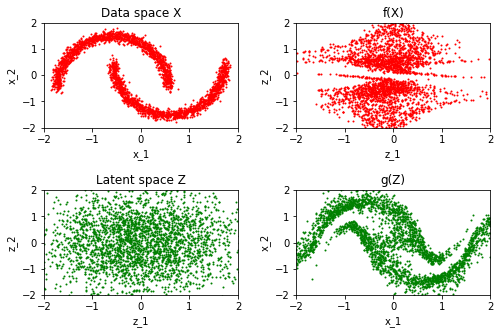

12/12 [==============================] - 2s 146ms/step - loss: 1.7189
Epoch 212/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7118
Epoch 213/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7157
Epoch 214/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7145
Epoch 215/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7236
Epoch 216/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7178
Epoch 217/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7109
Epoch 218/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7141
Epoch 219/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7085
Epoch 220/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7026
Epoch 221/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_220.png


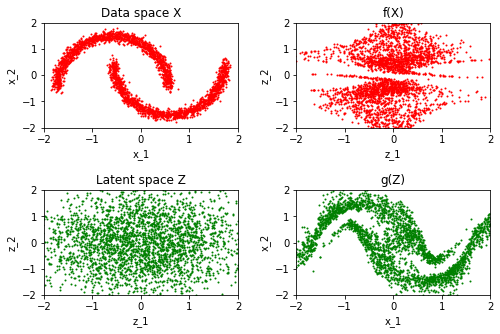

12/12 [==============================] - 1s 125ms/step - loss: 1.7119
Epoch 222/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7200
Epoch 223/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7312
Epoch 224/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7262
Epoch 225/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7192
Epoch 226/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7235
Epoch 227/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7089
Epoch 228/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7078
Epoch 229/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7122
Epoch 230/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7132
Epoch 231/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_230.png


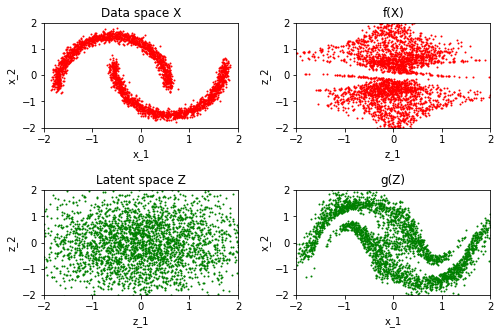

12/12 [==============================] - 2s 148ms/step - loss: 1.7111
Epoch 232/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7079
Epoch 233/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7132
Epoch 234/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7166
Epoch 235/300
12/12 [==============================] - 0s 18ms/step - loss: 1.6995
Epoch 236/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7050
Epoch 237/300
12/12 [==============================] - 0s 23ms/step - loss: 1.7049
Epoch 238/300
12/12 [==============================] - 0s 25ms/step - loss: 1.7153
Epoch 239/300
12/12 [==============================] - 0s 19ms/step - loss: 1.7098
Epoch 240/300
12/12 [==============================] - 0s 21ms/step - loss: 1.6998
Epoch 241/300
94/94 [==============================] - 1s 6ms/step

Saved to ./output/generated_img_240.png


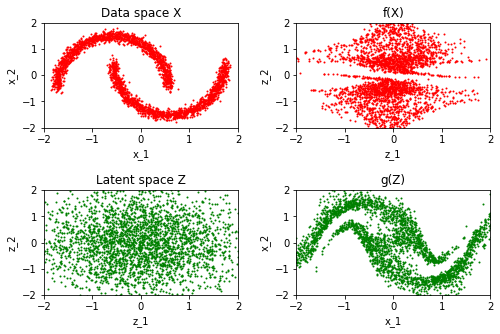

12/12 [==============================] - 2s 150ms/step - loss: 1.7083
Epoch 242/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7231
Epoch 243/300
12/12 [==============================] - 0s 22ms/step - loss: 1.7016
Epoch 244/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7093
Epoch 245/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7075
Epoch 246/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7218
Epoch 247/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7081
Epoch 248/300
12/12 [==============================] - 0s 23ms/step - loss: 1.7008
Epoch 249/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7184
Epoch 250/300
12/12 [==============================] - 0s 20ms/step - loss: 1.7042
Epoch 251/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_250.png


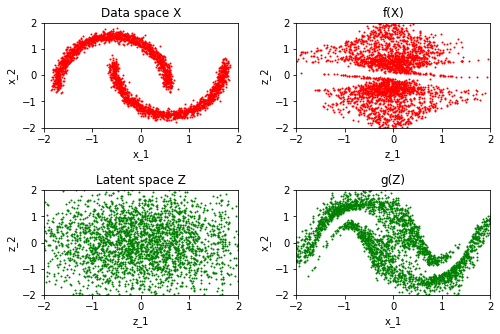

12/12 [==============================] - 1s 127ms/step - loss: 1.7038
Epoch 252/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7124
Epoch 253/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7154
Epoch 254/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7287
Epoch 255/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7546
Epoch 256/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7201
Epoch 257/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7021
Epoch 258/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7118
Epoch 259/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7071
Epoch 260/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7014
Epoch 261/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_260.png


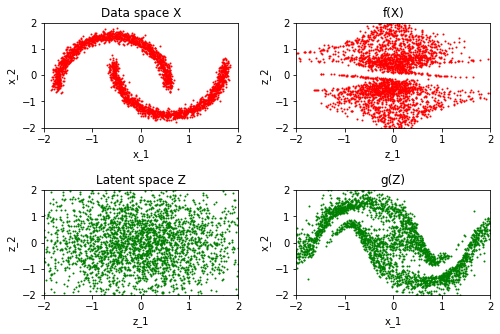

12/12 [==============================] - 1s 121ms/step - loss: 1.7035
Epoch 262/300
12/12 [==============================] - 0s 15ms/step - loss: 1.6945
Epoch 263/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7031
Epoch 264/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7102
Epoch 265/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7085
Epoch 266/300
12/12 [==============================] - 0s 15ms/step - loss: 1.6959
Epoch 267/300
12/12 [==============================] - 0s 17ms/step - loss: 1.7055
Epoch 268/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7106
Epoch 269/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7060
Epoch 270/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7189
Epoch 271/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_270.png


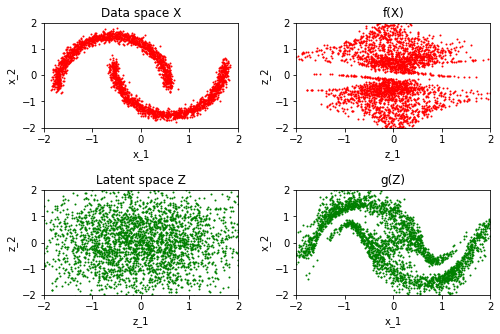

12/12 [==============================] - 1s 126ms/step - loss: 1.7153
Epoch 272/300
12/12 [==============================] - 0s 23ms/step - loss: 1.7082
Epoch 273/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7142
Epoch 274/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7230
Epoch 275/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7033
Epoch 276/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7161
Epoch 277/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7380
Epoch 278/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7080
Epoch 279/300
12/12 [==============================] - 0s 18ms/step - loss: 1.7109
Epoch 280/300
12/12 [==============================] - 0s 17ms/step - loss: 1.6993
Epoch 281/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_280.png


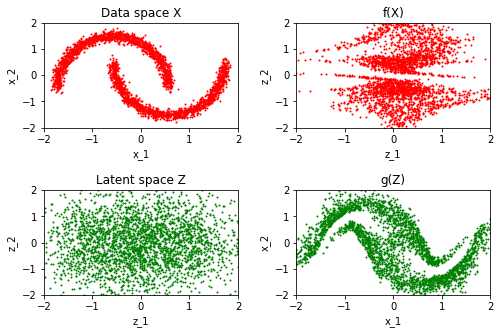

12/12 [==============================] - 2s 144ms/step - loss: 1.7231
Epoch 282/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7124
Epoch 283/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7037
Epoch 284/300
12/12 [==============================] - 0s 24ms/step - loss: 1.7056
Epoch 285/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7302
Epoch 286/300
12/12 [==============================] - 0s 16ms/step - loss: 1.7110
Epoch 287/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7199
Epoch 288/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7075
Epoch 289/300
12/12 [==============================] - 0s 14ms/step - loss: 1.6961
Epoch 290/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7013
Epoch 291/300
94/94 [==============================] - 0s 4ms/step

Saved to ./output/generated_img_290.png


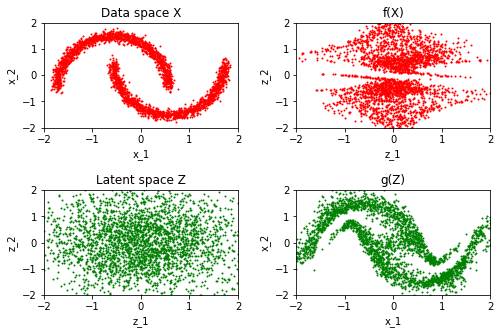

12/12 [==============================] - 1s 126ms/step - loss: 1.7084
Epoch 292/300
12/12 [==============================] - 0s 16ms/step - loss: 1.6967
Epoch 293/300
12/12 [==============================] - 0s 15ms/step - loss: 1.7054
Epoch 294/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7086
Epoch 295/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7039
Epoch 296/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7013
Epoch 297/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7131
Epoch 298/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7166
Epoch 299/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7035
Epoch 300/300
12/12 [==============================] - 0s 14ms/step - loss: 1.7008


In [9]:
model.fit(
    normalized_data
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , callbacks = [tensorboard_callback, img_generator_callback]
)

## 4. Generate images <a name="generate"></a>

In [10]:
x, z, samples = img_generator_callback.generate()

94/94 [==============================] - 0s 4ms/step


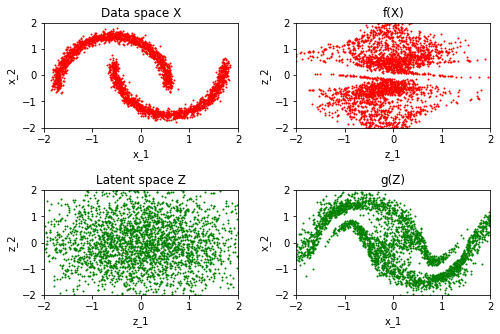

In [11]:
img_generator_callback.display(x, z, samples)